# Training Notbook

Data used are segment of pixels that are labelized from the classification of the polygons. The data are then used to train a model that will be used to predict the label of the pixels of the whole image.

### IMPORTS

In [1]:
from typing import Any
from model_components.k_means import CustomKMeans
import numpy as np
from model_components.CNN_model import Cplx_CustomCNN_1D
from model_components.Attention_Layer import AttentionLayer
from model_components.classification import CustomClassifierModel
import tensorflow as tf

import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

### DATA


We first load the data from the csv file, and remove unnecessary symbols.

In [2]:
df = pd.read_csv('Prepro_Data/post_processed_data.csv')

import pandas as pd
import numpy as np

def extract_multiple_arrays(string_repr):
    # Remove letters, parentheses, spaces, and unwanted sequences
    string_repr = re.sub('[a-df-zA-DF-Z\(\)\s]', '', string_repr)
    string_repr = re.sub(r',=32', '', string_repr)

    # Find all matches of arrays within the string
    arrays = re.findall(r'\[.*?\]', string_repr)

    # Convert each found array string into a NumPy array
    np_arrays = [np.array(re.findall(r'[+-]?\d+(?:\.\d+)?(?:e[+-]?\d+)?', array), dtype=float) for array in arrays]
    return np_arrays


In [3]:
# Apply extract_multiple_arrays to the 'pixels' column
df['pixels'] = df['pixels'].apply(extract_multiple_arrays)
print(df.head())

   Unnamed: 0  segment_id  polygon_id  class_id  \
0           0      367854         0.0       3.0   
1           1      367855         0.0       3.0   
2           2      367856         0.0       3.0   
3           3      369130         0.0       3.0   
4           4      363215         1.0       1.0   

                                              pixels  
0  [[0.44984567, 0.49691358, 0.40354937, 0.622685...  
1  [[0.55632716, 0.5578704, 0.50848764, 0.7075617...  
2  [[0.53780866, 0.5671296, 0.4699074, 0.69058645...  
3  [[0.5231481, 0.5532407, 0.44984567, 0.6705247,...  
4  [[0.38194445, 0.43904322, 0.24845679, 0.493055...  


#### Class distribution

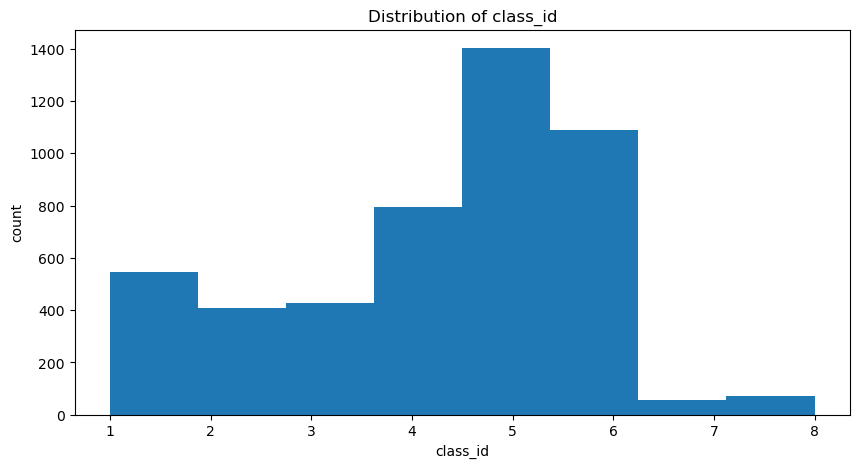

In [11]:
# Distribution of class_id
df['class_id'] = df['class_id'].astype('int8')
#print(df['class_id'].value_counts())
 
# Plot the distribution of class_id

plt.figure(figsize=(10, 5))
plt.hist(df['class_id'], bins=8)
plt.title('Distribution of class_id')
plt.xlabel('class_id')
plt.ylabel('count')
plt.show()

# -----

### THE ALGORITHM
-K-means

In [13]:
stacked_arrays = []

# Stack the arrays for each cell
for i, cell_pixels in enumerate(df['pixels']):
    stacked_array = np.vstack(cell_pixels)
    stacked_arrays.append(stacked_array)
    print(f'Cell {i} stacked.', end='\r')

In [14]:
print(len(stacked_arrays))
print(stacked_arrays[0].shape)

4795
(16, 730)


In [ ]:
n_clusters=2
custom_kmeans = CustomKMeans(n_clusters=n_clusters)

clustered_data = []
clustered_labels = []
for i in range (len(stacked_arrays)):
    custom_kmeans.fit(stacked_arrays[i])
    clustered_data.append(custom_kmeans.get_cluster_centers())
    clustered_labels.append(custom_kmeans.get_cluster_labels())

# _____

#### Data preparation, training and testing

In [21]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

clusters = np.array(clustered_data)
print("clusters shape:", clusters.shape)
labels = np.array(df['class_id'])- 1 # subtract 1 to have labels from 0 to 7

# Split the data into training and testing sets, with stratification
train_data, test_data, train_labels, test_labels = train_test_split(
    clusters, labels, test_size=0.2, random_state=42, stratify=labels
)
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
print("train_data shape:", train_data.shape)
print("train_labels shape:", train_labels.shape)
#print hte different possible labels
print("labels:", np.unique(labels))


clusters shape: (4795, 2, 73, 10)
train_data shape: (3836, 2, 73, 10)
train_labels shape: (3836, 8)
labels: [0 1 2 3 4 5 6 7]


#### The model

In [77]:
class Custom_Model(tf.keras.Model):
    '''
    This class defines the model architecture.
    '''
    
    def __init__(self):
        super(Custom_Model, self).__init__()
        self.enc = Cplx_CustomCNN_1D()
        self.attn = AttentionLayer()
        self.classifier = CustomClassifierModel(num_classes=8, fc_units=64) 

    def call(self, inputs):
        input_list = tf.unstack(inputs,axis=1) # from tensor to list
        intermediate = [self.enc(input) for input in input_list]
        intermediate = tf.stack(intermediate,axis=1)        
        emb, alphas = self.attn(intermediate)
        
        return self.classifier(emb)
    
    def get_alphas(self, inputs):
        input_list = tf.unstack(inputs,axis=1) # from tensor to list
        intermediate = [self.enc(input) for input in input_list]
        intermediate = tf.stack(intermediate,axis=1)        
        _, alphas = self.attn(intermediate)
        
        return alphas
        
    def initialize_model(self, input_shape):
        # Initialize the model by calling on random data to create the variables
        self.build(input_shape)
        dummy_data = tf.random.normal((1,) + input_shape)
        self.call(dummy_data)
        



In [78]:
from keras.optimizers.legacy import Adam as Adam_legacy
from keras.optimizers import Adam

lr = 0.001

model = Custom_Model()
optimizer = Adam_legacy(learning_rate=lr) # Use Adam if not on apple silicon
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
print(test_data.shape)
history = model.fit(train_data, train_labels, epochs=1, batch_size=32, validation_data=(test_data, test_labels))

(959, 2, 73, 10)
120/120 [==============================] - 42s 238ms/step - loss: 1.5798 - accuracy: 0.4116 - val_loss: 1.9725 - val_accuracy: 0.1950


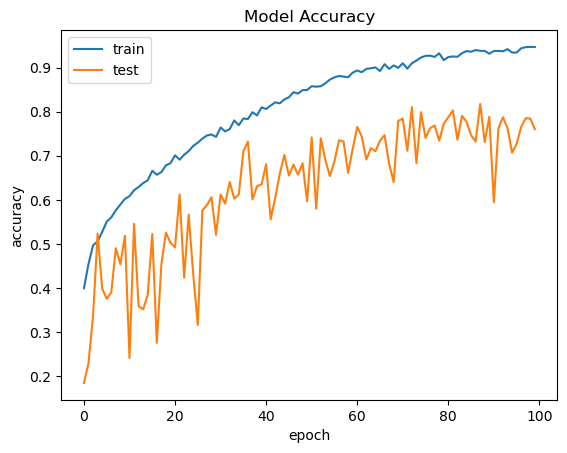

In [68]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Saving the model

In [69]:
SAVE_PATH = 'saved_models/'
model.save_weights(SAVE_PATH + 'model_weights_100_epochs2.h5')

-----------